<a href="https://colab.research.google.com/github/LokeshVadlamudi/DeepLearningClass/blob/master/finalTinMachine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Add Your tinder xauth Token ID

In [0]:
t = "54e65bf8-c7b1-40a8-809f-de2fc727147e"

#script for downloading the images from Tinder platform and store it in our drive

In [0]:
import requests

from geopy.geocoders import Nominatim
from time import sleep
from random import random


Locator = Nominatim(user_agent="TinMachine")
pFile = "/content/drive/My Drive/finalDL/pFile.txt"
tLink = "https://api.gotinder.com"

class tAPI():

    def __init__(self, t):
        self._t = t

    def nearest_peeps(self):
        print('inside nearest')
        d = requests.get(tLink + "/v2/recs/core", headers={"X-Auth-Token": self._t}).json()
        return list(map(lambda user: Peep(user["user"], self), d["data"]["results"]))


class Peep(object):

    def __init__(self, data, api):
        self._api = api

        self.id = data["_id"]
        self.name = data.get("name", "Unknown")

        self.gender = ["Male", "Female", "Unknown"][data.get("gender", 2)]

        self.images = list(map(lambda photo: photo["url"], data.get("photos", [])))

    def get_images(self, folder=".", sleep_max_for=0):
        print('inside download fn')

        with open(pFile, "r") as f:
            lines = f.readlines()
            if self.id in lines:
                return

        with open(pFile, "a") as f:
            f.write(self.id+"\r\n")

        index = -1
        for image_link in self.images:
            index += 1
            req = requests.get(image_link, stream=True)
            if req.status_code == 200:
                with open(f"{folder}/{self.id}_{self.name}_{index}.jpeg", "wb") as f:
                    f.write(req.content)
            sleep(random()*sleep_max_for)


if __name__ == "__main__":
    api = tAPI(t)
    print(api,'inside main')
    while True:
        peeps = api.nearest_peeps()
        print(peeps)
        for peep in peeps:
            print('inside person list')
            peep.get_images(folder="/content/drive/My Drive/finalDL/downloadedImages", sleep_max_for=random() * 3)
            sleep(random() * 10)

        sleep(random() * 10)

        

#now that we have our unclassified images, lets manually label them into like or dislike by renaming the files with either 1 or 0 respectively at front

#imageClassifier script

In [0]:
from os import listdir, rename
from os.path import isfile, join
import tkinter as tk
from PIL import ImageTk, Image

i_path = "/content/drive/My Drive/finalDL/downloadedImages"

images = [f for f in listdir(i_path) if isfile(join(i_path, f))]
unclassified_images = filter(lambda image: not (image.startswith("0_") or image.startswith("1_")), images)
current = None

def load_next():
    global current, unclassified_images
    try:
        current = next(unclassified_images)
    except StopIteration:
        root.quit()
        
    print(current)

    pil_img = Image.open(IMAGE_FOLDER+"/"+current)

    width, height = pil_img.size
    max_height = 1000

    if height > max_height:
        resize_factor = max_height / height
        pil_img = pil_img.resize((int(width*resize_factor), int(height*resize_factor)), resample=Image.LANCZOS)
    img_tk = ImageTk.PhotoImage(pil_img)
    img_label.img = img_tk
    img_label.config(image=img_label.img)

def likeCat(arg):
    global current
    print("like")
    rename(IMAGE_FOLDER+"/"+current, IMAGE_FOLDER+"/1_"+current)
    next_img()

def dislikeCat(arg):
    global current
    print("dislike")
    rename(IMAGE_FOLDER + "/" + current, IMAGE_FOLDER + "/0_" + current)
    next_img()


if __name__ == "__main__":

    root = tk.Tk()

    img_label = tk.Label(root)
    img_label.pack()
    #left mouse button for like
    #right mouse button for dislike 
    img_label.bind("<Button-1>", likeCat)
    img_label.bind("<Button-2>", dislikeCat)

    btn = tk.Button(root, text='Next image', command=load_next)

    load_next() # load first image

    root.mainloop()

#but since we are in colab, this tkinter can't generate the ui required for manually allowing us to classify, Paste the above script in local to generate the ui

#now that we have renamed using script, lets move these images to respective classified folders using moveImages Script below

In [0]:
import os

IMAGE_FOLDER = "/content/drive/My Drive/finalDL/downloadedImages"
POS_FOLDER = "/content/drive/My Drive/finalDL/classified/liked"
NEG_FOLDER = "/content/drive/My Drive/finalDL/classified/disliked"

if __name__ == "__main__":

    images = [f for f in os.listdir(IMAGE_FOLDER) if os.path.isfile(os.path.join(IMAGE_FOLDER, f))]
    liked_images = filter(lambda image: (image.startswith("1_")), images)
    disliked_images = filter(lambda image: (image.startswith("0_")), images)

  
    #iterate through liked pics
    for liked in liked_images:
        old_filename = IMAGE_FOLDER + "/" + liked
        new_filename = POS_FOLDER + "/" + liked[:-5] + ".jpg"

        if not os.path.isfile(new_filename):
            print("moving to liked folder: " + liked)
            img = old_filename
            if not img:
                continue
            img.save(new_filename, "jpeg")

    #iterate through disliked pics
    for disliked in disliked_images:
        old_filename = IMAGE_FOLDER + "/" + disliked
        new_filename = NEG_FOLDER + "/" + disliked[:-5] + ".jpg"
        if not os.path.isfile(new_filename):
            print("moving to disliked folder: " + disliked)
            img = old_filename
            if not img:
                continue
            img.save(new_filename, "jpeg")

#lets train our model based on Liked and Disliked Pics

In [7]:
pip install fastai==1.0.60

     |████████████████████████████████| 245kB 4.8MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
import pandas as pd

In [9]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 18kB/s 
     |████████████████████████████████| 4.0MB 44.1MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path='/content/drive/My Drive/finalDL/classified'
data = (ImageList.from_folder(path) .split_by_rand_pct() .label_from_folder()  .transform(get_transforms(), size=224) .databunch())

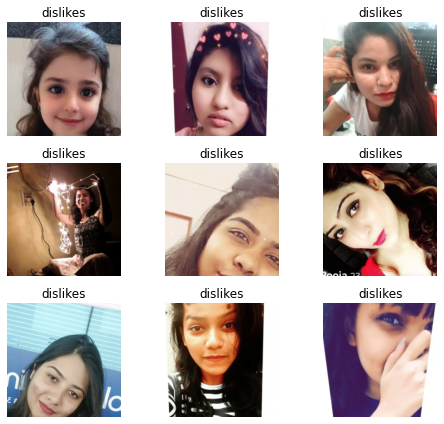

In [0]:
data.show_batch(rows=3, figsize=(7,6))

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.086776,1.086769,0.380392,02:37
1,0.782495,0.192660,0.074510,00:42
2,0.591441,0.125001,0.039216,00:39
3,0.459069,0.127246,0.043137,00:39


In [0]:
learn.unfreeze()

#importing opencv

In [0]:
# !pip install opencv-python

In [0]:
import cv2

#setting size 

In [0]:
sz = 1500

#function to convert image to tensor form

In [0]:
def imageToTensorImage(path):
  bgr_img = cv2.imread(path)
  b,g,r = cv2.split(bgr_img)
  rgb_img = cv2.merge([r,g,b])
  H,W,C = rgb_img.shape
  rgb_img = rgb_img[(H-sz)//2:(sz +(H-sz)//2),(H-sz)//2:(sz +(H-sz)//2),:] / 256
  return vision.Image(px=pil2tensor(rgb_img, np.float32))

#predicting a sample image

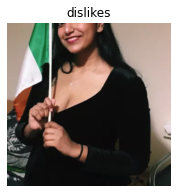

In [0]:
img = imageToTensorImage('/content/drive/My Drive/finalDL/classified/dislikes/1_Screen Shot 2020-04-13 at 12.26.54 AM.png')

## predict and visualize
img.show(y=learn.predict(img)[0])

In [0]:
y=learn.predict(img)[0]

In [0]:
print(y)

dislikes


#export weights

In [0]:
learn.export()

#load pickle that we saved above and predict an image

In [0]:
# nn = load_learner('/content/drive/My Drive/datasets')

In [0]:
# nn.predict(img)[0]

#main script for running the application in django

#this script will be shown in the video as it requires all the django files

In [0]:
from django.shortcuts import render
import requests
import datetime
from geopy.geocoders import Nominatim
import cv2
from fastai import *
from fastai.tabular import *
from torchvision.models import *
from fastai.vision import *


def default_view(request):
    return render(request, 'base.html')


TINDER_URL = "https://api.gotinder.com"
geolocator = Nominatim(user_agent="DLTinMachine")
PROF_FILE = "/content/drive/My Drive/finalDL/pFile.txt"
#PROF_FILE = "profiles.txt"


class tinderAPI():

    def __init__(self, token):
        self._token = token

    def like(self, user_id):
        data = requests.get(TINDER_URL + f"/like/{user_id}", headers={"X-Auth-Token": self._token}).json()
        return {
            "is_match": data["match"],
            "liked_remaining": data["likes_remaining"]
        }

    def dislike(self, user_id):
        requests.get(TINDER_URL + f"/pass/{user_id}", headers={"X-Auth-Token": self._token}).json()
        return True

    def nearby_persons(self):
        print('inside nearby')
        data = requests.get(TINDER_URL + "/v2/recs/core", headers={"X-Auth-Token": self._token}).json()
        print(data)
        return list(map(lambda user: Person(user["user"], self), data["data"]["results"]))


class Person(object):

    def __init__(self, data, api):
        self._api = api

        self.id = data["_id"]
        self.name = data.get("name", "Unknown")

        self.bio = data.get("bio", "")
        self.distance = data.get("distance_mi", 0) / 1.60934

        self.birth_date = datetime.datetime.strptime(data["birth_date"], '%Y-%m-%dT%H:%M:%S.%fZ') if data.get(
            "birth_date", False) else None
        self.gender = ["Male", "Female", "Unknown"][data.get("gender", 2)]

        self.images = list(map(lambda photo: photo["url"], data.get("photos", [])))

        self.jobs = list(
            map(lambda job: {"title": job.get("title", {}).get("name"), "company": job.get("company", {}).get("name")},
                data.get("jobs", [])))
        self.schools = list(map(lambda school: school["name"], data.get("schools", [])))

        if data.get("pos", False):
            self.location = geolocator.reverse(f'{data["pos"]["lat"]}, {data["pos"]["lon"]}')

    def __repr__(self):
        return f"{self.id}  -  {self.name} ({self.birth_date.strftime('%d.%m.%Y')})"

    def like(self):
        return self._api.like(self.id)

    def dislike(self):
        return self._api.dislike(self.id)


token = "54e65bf8-c7b1-40a8-809f-de2fc727147e"
api = tinderAPI(token)
print(api, 'inside main')


def default_view2(request):
    persons = api.nearby_persons()
    peeps = []
    count = 0
    for person in persons:

        print("-------------------------")
        print("ID: ", person.id)
        print("Name: ", person.name)
        print("Schools: ", person.schools)
        image_url = person.images[0]
        print(os.getcwd())
        req = requests.get(image_url, stream=True)
        folder = "images"

        # create folder if not exists
        if not os.path.exists(folder):
            os.makedirs(folder)

        name = person.name
        # school = person.schools
        if req.status_code == 200:
            with open(f"{folder}/{name}.jpeg", "wb") as f:
                f.write(req.content)

        sz = 1500

        def imageToTensorImage(path):
            bgr_img = cv2.imread(path)
            b, g, r = cv2.split(bgr_img)
            rgb_img = cv2.merge([r, g, b])
            H, W, C = rgb_img.shape
            rgb_img = rgb_img[(H - sz) // 2:(sz + (H - sz) // 2), (H - sz) // 2:(sz + (H - sz) // 2), :] / 256
            return vision.Image(px=pil2tensor(rgb_img, np.float32))

        learn = load_learner('DLTinMachine/')
        img = imageToTensorImage('images/' + name + '.jpeg')

        # predict and visualize
        y = learn.predict(img)[0]
        print(y)
        count += 1
        status = ''
        if str(y) == 'likes':
            res = person.like()
            print("LIKE")
            print("Response: ", res)
            status = 'LIKE'
        else:
            res = person.dislike()
            print("DISLIKE")
            print("Response: ", res)
            status = 'DISLIKE'
        peeps.append({'name': name, 'url': image_url, 'status': status})
        if count == 3:
            break

    context = {
        'peeps': peeps,
    }
    return render(request, 'tinner.html', context)
